In [2]:
import torch 
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from train import train
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
data = pd.read_csv("/Users/maxkucher/shelling /aviation.csv")
data = data.drop("Unnamed: 0", axis="columns")
data

,aap_ammount,ah_ammount,th_ammount,ta_ammount,manpads_ammount,sam_ammount,descision
0,0,0,0,1,0,0,2
1,0,0,0,1,0,1,1
2,0,0,0,1,0,2,1
3,0,0,0,1,0,3,1
4,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...
4075,3,3,3,3,2,3,3
4076,3,3,3,3,3,0,5
4077,3,3,3,3,3,1,3
4078,3,3,3,3,3,2,3


In [5]:
x = data.drop("descision", axis="columns")
y = data["descision"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

In [6]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x.values)
        self.y = torch.LongTensor(y.values)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [7]:
train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)

In [8]:
train_dataset[0]

(tensor([1., 0., 3., 2., 1., 1.]), tensor(3))

In [9]:
batch_size = 32

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))

In [10]:
x_train.shape

(3264, 6)

In [11]:
y_train.value_counts()

descision
3    1634
5     641
4     545
2     240
1     125
0      79
Name: count, dtype: int64

In [12]:
class AviationModel(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()

        self.linear1 = nn.Linear(in_features = 6, out_features = 24)
        self.bnorm1 = nn.BatchNorm1d(num_features = 24)
        self.linear2 = nn.Linear(in_features = 24, out_features = 24)
        self.drop1 = nn.Dropout(0.2)
        self.linear3 = nn.Linear(in_features = 24, out_features = 12)
        self.linear4 = nn.Linear(in_features = 12, out_features = num_classes)

    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.bnorm1(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.drop1(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)

        return out 


    def predict(self, x, device="cpu"):

        x = torch.FloatTensor(x).to(device)
        with torch.no_grad():
            y_pred = F.softmax(self.forward(x), dim=-1)

        return y_pred
    


model = AviationModel().to(device)

model

AviationModel(
  (linear1): Linear(in_features=6, out_features=24, bias=True)
  (bnorm1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=24, out_features=24, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (linear3): Linear(in_features=24, out_features=12, bias=True)
  (linear4): Linear(in_features=12, out_features=6, bias=True)
)

In [13]:
%pip install -q torchsummary

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [14]:
from torchsummary import summary

summary(model, input_size=(6, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 24]             168
       BatchNorm1d-2                   [-1, 24]              48
            Linear-3                   [-1, 24]             600
           Dropout-4                   [-1, 24]               0
            Linear-5                   [-1, 12]             300
            Linear-6                    [-1, 6]              78
Total params: 1,194
Trainable params: 1,194
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [15]:
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [16]:
history = train(model, optimizer, loss_func, train_dl, test_dl, [accuracy_score],
                epochs=20, device=device, task="multiclass")

Epoch    1    0sec	loss:        1.4	val_loss:      0.975	accuracy_score:      0.544	val_accuracy_score:      0.647	
Epoch    2    0sec	loss:      0.824	val_loss:      0.647	accuracy_score:      0.689	val_accuracy_score:      0.734	
Epoch    3    0sec	loss:      0.565	val_loss:      0.376	accuracy_score:      0.823	val_accuracy_score:      0.898	
Epoch    4    0sec	loss:      0.368	val_loss:      0.259	accuracy_score:      0.882	val_accuracy_score:      0.903	
Epoch    5    0sec	loss:      0.288	val_loss:      0.207	accuracy_score:      0.903	val_accuracy_score:      0.904	
Epoch    6    0sec	loss:       0.25	val_loss:      0.174	accuracy_score:      0.907	val_accuracy_score:      0.911	
Epoch    7    0sec	loss:      0.224	val_loss:       0.16	accuracy_score:      0.916	val_accuracy_score:      0.917	
Epoch    8    0sec	loss:        0.2	val_loss:      0.139	accuracy_score:      0.918	val_accuracy_score:       0.94	
Epoch    9    0sec	loss:      0.181	val_loss:       0.12	accuracy_score:

In [17]:
loader = DataLoader(test_dataset, batch_size=len(test_dataset))
x_test, y_test = next(iter(loader))

y_pred = model.predict(x_test)

predicted_classes = torch.argmax(y_pred, dim=1).cpu().numpy()

print(predicted_classes)

[3 5 0 3 5 4 5 5 3 3 3 5 3 3 3 2 0 5 0 3 2 2 3 5 5 1 3 2 5 0 3 5 2 4 3 3 5
 3 3 4 5 3 4 4 3 3 2 2 2 5 5 3 2 3 3 4 5 5 5 4 3 3 4 3 3 5 5 4 5 4 3 3 1 3
 4 3 3 4 5 5 4 3 3 3 5 5 4 3 2 5 3 2 3 3 4 3 1 4 0 5 3 5 3 3 5 3 4 1 3 1 3
 4 3 3 5 3 2 5 5 3 5 5 4 3 4 4 0 2 3 5 3 3 4 4 4 3 5 4 5 3 4 3 2 3 3 2 4 3
 1 3 3 2 5 3 3 2 5 3 2 5 4 5 3 4 5 3 2 5 5 4 5 5 4 3 3 3 2 3 5 3 3 3 5 2 3
 5 3 3 3 4 4 3 3 4 3 3 4 4 3 3 3 3 1 0 4 4 4 3 4 5 3 5 1 1 5 0 1 4 1 3 3 3
 3 3 4 3 1 4 3 3 4 0 3 3 3 4 3 2 3 4 0 5 3 5 3 3 5 3 3 5 4 3 3 4 0 5 5 1 3
 3 5 4 3 1 3 5 4 3 5 3 3 3 3 3 3 3 3 5 3 3 2 3 5 3 3 3 3 5 3 5 3 3 3 3 3 3
 3 3 3 1 5 4 5 4 4 3 3 3 5 3 2 3 4 5 4 3 1 3 2 2 3 3 2 4 5 3 5 5 4 3 5 3 3
 2 3 3 3 3 3 4 3 1 1 4 4 4 3 3 3 3 3 3 5 4 5 3 3 3 4 5 3 3 5 0 1 5 5 4 2 0
 3 4 3 3 3 3 3 3 4 3 3 5 2 3 3 3 3 3 3 5 2 3 3 5 4 3 5 5 3 5 1 2 3 3 4 3 4
 3 4 3 3 4 1 2 3 3 3 3 3 5 3 3 5 3 4 4 3 5 5 4 3 3 3 5 3 3 5 3 3 3 3 5 3 3
 3 5 0 3 4 3 5 3 3 3 1 3 3 5 3 3 4 3 4 3 3 5 3 4 4 1 4 2 3 3 3 3 5 4 3 5 3
 3 3 3 0 3 3 4 3 3 3 5 3 

In [18]:
data[data["descision"] == 6]

,aap_ammount,ah_ammount,th_ammount,ta_ammount,manpads_ammount,sam_ammount,descision


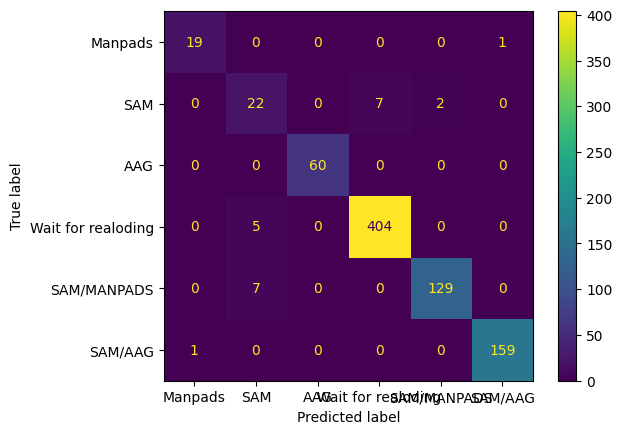

In [19]:
commands = ["Manpads", "SAM", "AAG", "Wait for realoding", "SAM/MANPADS", "SAM/AAG"]

ConfusionMatrixDisplay.from_predictions(y_test, predicted_classes, display_labels=commands)

In [20]:
data[data["descision"] == 0].head(1)

,aap_ammount,ah_ammount,th_ammount,ta_ammount,manpads_ammount,sam_ammount,descision
4,0,0,0,1,1,0,0


In [21]:
import torch
data = [0, 0, 0, 1, 1, 0]

x = torch.FloatTensor(data).unsqueeze(0).to(device)

y_pred = model.predict(x, device=device)

t_r = torch.argmax(y_pred)

r = np.array(t_r)

print(commands[r])

Manpads


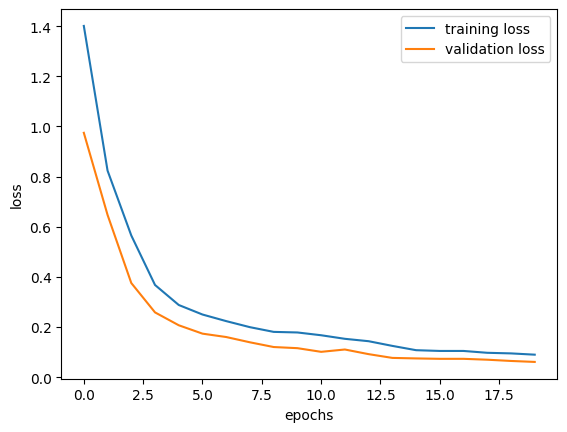

In [22]:
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [23]:
# torch.save(model, "aviation.pt")

In [24]:
torch.save(model.state_dict(), "aviation.pt")